In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings("ignore")
%matplotlib inline

c:\users\u618266\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\u618266\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\u618266\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv("data/bs140513_032310.csv")
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
df.drop(['step', 'age','gender','zipcodeOri','zipMerchant'], axis=1, inplace=True)
df.head()

,customer,merchant,category,amount,fraud
0,'C1093826151','M348934600','es_transportation',4.55,0
1,'C352968107','M348934600','es_transportation',39.68,0
2,'C2054744914','M1823072687','es_transportation',26.89,0
3,'C1760612790','M348934600','es_transportation',17.25,0
4,'C757503768','M348934600','es_transportation',35.72,0


In [4]:
# Opening JSON file
f = open('data/graph_features.json')
data = json.load(f)

In [5]:
graph_features = {}
for d in data:
    graph_features[d['id']] = {'degree': d['degree'], 'pagerank': d['pagerank'], 'community': d['community']}

In [6]:
# Helper functions to add network features to input dataframe 
def addDegree(x):
    return graph_features[x]['degree']
def addCommunity(x):
    return str(graph_features[x]['community'])
def addPagerank(x):
    return graph_features[x]['pagerank']

In [7]:
df['custPageRank'] = df.customer.apply(addPagerank)
df['merchPageRank'] = df.merchant.apply(addPagerank)
df['merchDegree'] = df.merchant.apply(addDegree)
df['custDegree'] = df.customer.apply(addDegree)
df['merchCommunity'] = df.merchant.apply(addCommunity)
df['custCommunity'] = df.customer.apply(addCommunity)

In [8]:
label = df.fraud

In [9]:
features_graph = df.drop('fraud', axis = 1)

In [10]:
scaler = MinMaxScaler()
df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']] = scaler.fit_transform(df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']])
features_graph[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']] = df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']]

In [11]:
final_features = pd.get_dummies(features_graph)

In [12]:
final_features.head()

,amount,custPageRank,merchPageRank,merchDegree,custDegree,customer_'C1000148617',customer_'C100045114',customer_'C1000699316',customer_'C1001065306',customer_'C1002658784',...,merchCommunity_608544,merchCommunity_608545,merchCommunity_608546,merchCommunity_608547,custCommunity_608498,custCommunity_608499,custCommunity_608500,custCommunity_608501,custCommunity_608504,custCommunity_608505
0,0.000546,0.0,1.000000,1.000000,0.172414,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.004764,0.0,1.000000,1.000000,0.344828,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.003228,0.0,0.888913,0.909322,0.413793,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.002071,0.0,1.000000,1.000000,0.310345,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.004288,0.0,1.000000,1.000000,0.413793,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
print("counts of label '1': {}".format(sum(label == 1)))
print("counts of label '0': {} \n".format(sum(label == 0)))

counts of label '1': 7200
counts of label '0': 587443 



In [13]:
type(label)

pandas.core.series.Series

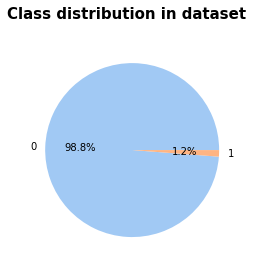

In [14]:
fig,ax=plt.subplots(1,1)
plt.pie(x=label.value_counts(),labels=["0","1"],colors=sns.color_palette('pastel'),autopct="%.1f%%")
fig.suptitle("Class distribution in dataset",y=1,fontweight="bold",fontsize=15)
plt.show()

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def plot_roc(predictions_prob, y_test_enh, ns_probs, model):
  lr_probs = predictions_prob[:, 1]
  ns_auc = roc_auc_score(y_test_enh, ns_probs)
  lr_auc = roc_auc_score(y_test_enh, lr_probs)
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print(model+': ROC AUC=%.3f' % (lr_auc))
  ns_fpr, ns_tpr, _ = roc_curve(y_test_enh, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test_enh, lr_probs)
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label=model)
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.legend()

In [17]:
label_list = list(label)
test_data = df.iloc[[label_list.index(1)]] ## ground truth: fraud
test_data = test_data.append(df.iloc[[label_list.index(0)]]) ## ground truth: no fraud
test_data.head()

,customer,merchant,category,amount,fraud,custPageRank,merchPageRank,merchDegree,custDegree,merchCommunity,custCommunity
88,'C583110837','M480139044','es_health',0.005313,1,0.0,0.298948,0.336475,0.448276,608504,608498
0,'C1093826151','M348934600','es_transportation',0.000546,0,0.0,1.000000,1.000000,0.172414,608498,608498


In [18]:
## extracting features for test data

test_fraud = final_features.iloc[[label_list.index(1)]]
test_no_fraud = final_features.iloc[[label_list.index(0)]]
test_data = test_fraud.append(test_no_fraud)

## Model training without oversampling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(final_features, label, test_size = 0.3)

In [22]:
ns_probs = [0 for _ in range(len(y_test))]

In [23]:
%%time 
rf = RandomForestClassifier()
rf.fit(X_train, y_train.ravel())
predictions = rf.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176213
           1       0.88      0.80      0.84      2180

    accuracy                           1.00    178393
   macro avg       0.94      0.90      0.92    178393
weighted avg       1.00      1.00      1.00    178393

Wall time: 5min 53s


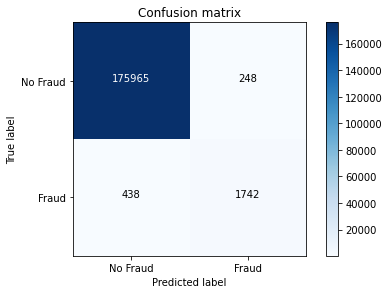

In [24]:
cnf_matrix_tra = confusion_matrix(y_test, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.988


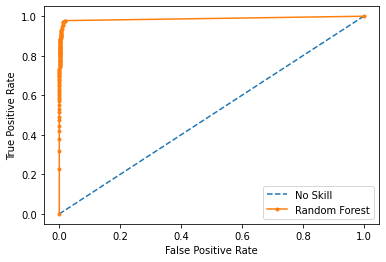

In [25]:
predictions_prob = rf.predict_proba(X_test)
plot_roc(predictions_prob, y_test, ns_probs, 'Random Forest')
pyplot.show()

In [26]:
%%time 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.ravel())
predictions = knn.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176213
           1       0.87      0.75      0.80      2180

    accuracy                           1.00    178393
   macro avg       0.93      0.87      0.90    178393
weighted avg       1.00      1.00      1.00    178393

Wall time: 3h 30min 12s


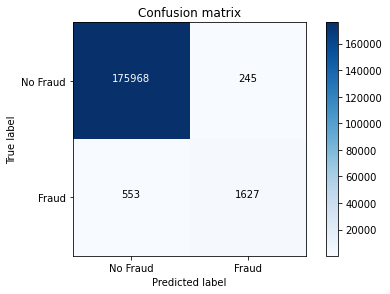

In [27]:
cnf_matrix_tra = confusion_matrix(y_test, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.959


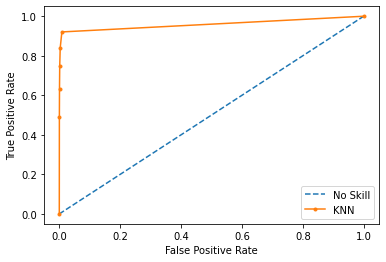

In [28]:
predictions_prob = knn.predict_proba(X_test)
plot_roc(predictions_prob, y_test, ns_probs, 'KNN')
pyplot.show()

In [30]:
%%time 
xgb = XGBClassifier()
xgb.fit(X_train, y_train.ravel())
predictions = xgb.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176213
           1       0.89      0.80      0.84      2180

    accuracy                           1.00    178393
   macro avg       0.94      0.90      0.92    178393
weighted avg       1.00      1.00      1.00    178393

Wall time: 12min 42s


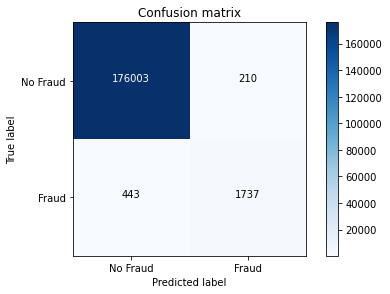

In [31]:
cnf_matrix_tra = confusion_matrix(y_test, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.998


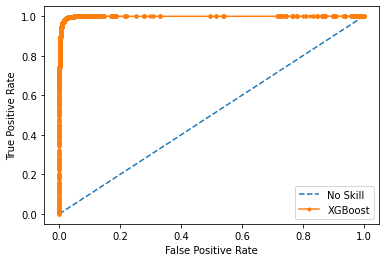

In [32]:
predictions_prob = xgb.predict_proba(X_test)
plot_roc(predictions_prob, y_test, ns_probs, 'XGBoost')
pyplot.show()

testing the model with one fraud and one non fraud instance

In [33]:
## testing using different models. 0-->no fraud  1-->fraud

predicted_results = {}
predicted_results['random forest'] = rf.predict(test_data)
predicted_results['KNN'] = knn.predict(test_data)
predicted_results['XGBoost'] = xgb.predict(test_data)

print(predicted_results)

{'random forest': array([0, 0], dtype=int64), 'KNN': array([0, 0], dtype=int64), 'XGBoost': array([0, 0])}


# Using Smote to oversample the data

In [17]:
## oversampling minority class (fraud=1) using SMOTE for training set

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2, sampling_strategy=0.3)
X_train_res, y_train_res = sm.fit_resample(X_train_enh, y_train_enh.ravel())

In [18]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_enh == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(y_train_enh == 0)))

Before OverSampling, counts of label '1': 5756
Before OverSampling, counts of label '0': 469958


In [20]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, counts of label '1': 140987
After OverSampling, counts of label '0': 469958


In [25]:
## oversampling minority class (fraud=1) using SMOTE for test set

X_test_res, y_test_res = sm.fit_resample(X_test_enh, y_test_enh.ravel())

In [26]:
print("Before OverSampling, counts of label '1' in test data: {}".format(sum(y_test_enh == 1)))
print("Before OverSampling, counts of label '0' in test data: {}".format(sum(y_test_enh == 0)))

Before OverSampling, counts of label '1' in test data: 1444
Before OverSampling, counts of label '0' in test data: 117485


In [27]:
print("Before OverSampling, counts of label '1' in test data: {}".format(sum(y_test_res == 1)))
print("Before OverSampling, counts of label '0' in test data: {}".format(sum(y_test_res == 0)))

Before OverSampling, counts of label '1' in test data: 35245
Before OverSampling, counts of label '0' in test data: 117485


In [32]:
ns_probs = [0 for _ in range(len(y_test_res))]


#Model Training with oversampling minority class

Random Forest

In [29]:
%%time 
rf_oversample = RandomForestClassifier()
rf_oversample.fit(X_train_res, y_train_res.ravel())
predictions = rf_oversample.predict(X_test_res)
  
# print classification report
print(classification_report(y_test_res, predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    117485
           1       0.94      0.99      0.97     35245

    accuracy                           0.98    152730
   macro avg       0.97      0.99      0.98    152730
weighted avg       0.98      0.98      0.98    152730



confusion matrix for test data using random forest

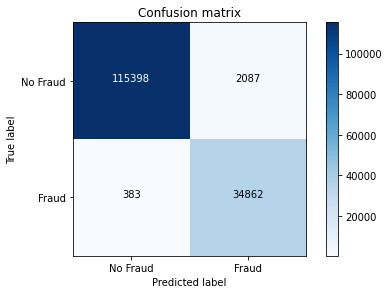

In [30]:
cnf_matrix_tra = confusion_matrix(y_test_res, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.998


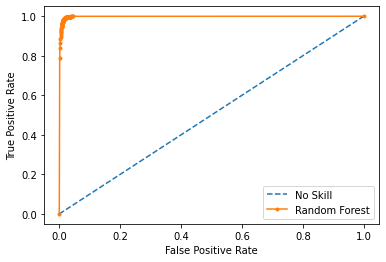

In [33]:
predictions_prob = rf_oversample.predict_proba(X_test_res)
plot_roc(predictions_prob, y_test_res, ns_probs, 'Random Forest')
pyplot.show()

KNN

In [ ]:
%%time 
knn_oversample = KNeighborsClassifier(n_neighbors=5)
knn_oversample.fit(X_train_res, y_train_res.ravel())
predictions = knn_oversample.predict(X_test_res)
  
# print classification report
print(classification_report(y_test_enh, predictions))

confusion matrix for test data using KNN

In [ ]:
cnf_matrix_tra = confusion_matrix(y_test_res, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
predictions_prob = knn_oversample.predict_proba(X_test_res)
plot_roc(predictions_prob, y_test_res, ns_probs, 'KNN')
pyplot.show()

XGBoost

In [ ]:
%%time 
xgb_oversample = XGBClassifier()
xgb_oversample.fit(X_train_res, y_train_res.ravel())
predictions = xgb_oversample.predict(X_test_res)
  
# print classification report
print(classification_report(y_test_res, predictions))

confusion matrix for test data using XGBoost

In [ ]:
cnf_matrix_tra = confusion_matrix(y_test_res, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
predictions_prob = xgb_oversample.predict_proba(X_test_res)
plot_roc(predictions_prob, y_test_res, ns_probs, 'Random Forest')
pyplot.show()

testing the model with one fraud and one non fraud instance

In [ ]:
## testing using different models. 0-->no fraud  1-->fraud

predicted_results = {}
predicted_results['random forest'] = rf_oversample.predict(test_data)
predicted_results['KNN'] = knn_oversample.predict(test_data)
predicted_results['XGBoost'] = xgb_oversample.predict(test_data)

print(predicted_results)

In [ ]:
!pip install spektral

In [ ]:
adj, features, labels, 